# Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.applications import vgg16   #Modèle de référence
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, Dropout
from keras.utils import load_img, img_to_array, to_categorical

from sklearn.metrics import log_loss, balanced_accuracy_score, accuracy_score
from time import time
from glob import glob

# Pour DecompressionBomb Warning:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import cv2
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
'''
Pré traitement des images (Notebook précédent)
'''
def image_prep(data, module) :
    prepared_images = []
    for i in data['image_name'].index :
        img = img_to_array(load_img('/content/drive/MyDrive/Colab Notebooks/Projet 6/Images/'+str(data['image_name'][i]),
               target_size=(224, 224)))
        img = img.reshape(img.shape[0], img.shape[1], img.shape[2])
        prepared_images.append(module.preprocess_input(img))
    return np.array(prepared_images)
'''
Split data + prétraitement en fonction du module
'''
def split_prep(module):
  y = to_categorical(data.label)
  X = data.drop(columns=['label'])

  Xtr, Xte, ytr, yte = train_test_split(X, y, train_size=0.7)
  # preparation des images selon le module
  with tf.device('/gpu:0'):
    Xtr = image_prep(Xtr, module)
    Xte = image_prep(Xte, module)

  Xtr, Xval, ytr, yval = train_test_split(Xtr, ytr, train_size=0.8)
  return Xtr, Xval, Xte, ytr, yval, yte

'''
Création modèle VGG16 : modèle de référence
'''
def create_vgg16() :
    # Récupération modèle pré-entraîné
    model0 = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
      layer.trainable = False
    # Récupérer la sortie
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(378, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(data.label.nunique(), activation='softmax')(x)
    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

'''
Scores du modèle : evaluate(), balanced_accuracy_score(), overfitting index
'''
def scores(model, column):

  loss_tr, accuracy_tr = model.evaluate(Xtr, ytr, verbose=False)
  loss_val, accuracy_val = model.evaluate(Xval, yval, verbose=False)
  loss_te, accuracy_te = model.evaluate(Xte, yte, verbose=False)
  print(f"Losses (training/validation/test) : {round(loss_tr, 2)}/{round(loss_val, 2)}/{round(loss_te, 2)}")

  y_pred_list = model.predict(Xte, verbose=0).argmax(axis=1)

  comp[column] = [accuracy_tr, accuracy_val, accuracy_te,
                  balanced_accuracy_score(yte.argmax(axis=1), y_pred_list),
                  accuracy_tr-(np.mean([accuracy_val, accuracy_te]))]

  return comp

'''
Création modèle VGG16 avec data augmentation
'''
def create_vgg16_2() :
    # Même modèle de base
    model0 = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
      layer.trainable = False
    # Layers de data augmentation :
    data_augmentation = tf.keras.Sequential([RandomFlip(input_shape=(224, 224, 3)),
                                             RandomRotation((-0.1, 0.1)),
                                             RandomZoom((-0.1, 0.1))])
    # Compléter le modèle
    model = tf.keras.Sequential([data_augmentation,
                                 model0,
                                 GlobalAveragePooling2D(),
                                 Dense(378, activation='relu'),
                                 Dropout(0.5),
                                 Dense(data.label.nunique(), activation='softmax')])
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet 6/flipkart_com-ecommerce_sample_1050.csv')
print(f"Dimensions de l'échantillon : {sample.shape}")

data0 = sample.loc[:, ['uniq_id', 'image']]
data0.rename(columns={'image' : 'image_name'}, inplace=True)
data0['product_category'] = sample['product_category_tree'].str.split('"', expand=True)[1].str.split(">>", expand=True)[2].str.lower()

Dimensions de l'échantillon : (1050, 15)


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Projet 6/Images/'

data_path = glob(path+'*.jp*')

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["image_name"] = pd.Series(list_photos).str.split('/', expand=True)[7]
    data["label_name"] = data.merge(data0, on='image_name', how='left').loc[:, 'product_category']
    return data

data = data_fct(data_path)

le = LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

data.head(5)

1050


,image_path,image_name,label_name,label
0,/content/drive/MyDrive/Colab Notebooks/Projet ...,0dc4d2767fe8424a3263ab141884f83d.jpg,romex wrist watches,189
1,/content/drive/MyDrive/Colab Notebooks/Projet ...,0d3e1dc0d38be59e9927e47f152e48aa.jpg,prithish coffee mugs,178
2,/content/drive/MyDrive/Colab Notebooks/Projet ...,0bb0f7b7a3075f4b9459121abe2185fa.jpg,table lamps,215
3,/content/drive/MyDrive/Colab Notebooks/Projet ...,0f4f761de4224b004402c1f97e871ba4.jpg,bar glasses,22
4,/content/drive/MyDrive/Colab Notebooks/Projet ...,0d02f4703fde00645704e15bba23e77d.jpg,batteries,26


# Prétraitement

In [ ]:
print(data.isna().sum())

image_path    0
image_name    0
label_name    3
label         0
dtype: int64


In [ ]:
data = data.loc[~data['label_name'].isna()]
print(f"Nouvelles dimensions : {data.shape}\nNombre de valeurs manquantes : {data.isna().sum().sum()}")

Nouvelles dimensions : (1047, 4)
Nombre de valeurs manquantes : 0


1. Split + preprocess_input

In [ ]:
Xtr, Xval, Xte, ytr, yval, yte = split_prep(vgg16)

print(f"Training data shape : {Xtr.shape}\nTesting data shape : {Xte.shape}\nValidation data shape : {Xval.shape}")
print()
print(f"Training target shape : {ytr.shape}\nTesting target shape : {yte.shape}\nValidation target shape : {yval.shape}")

Training data shape : (585, 224, 224, 3)
Testing data shape : (315, 224, 224, 3)
Validation data shape : (147, 224, 224, 3)

Training target shape : (585, 244)
Testing target shape : (315, 244)
Validation target shape : (147, 244)


shape X = (Nombre d'images, Taille des images)

shape y = (Nombre d'images, nombre de catégories présentes)


# Premier modèle : modèle de référence

Vu dans le notebook précédent.

In [ ]:
# création et entraînement du modèle de référence
model_vgg16 = create_vgg16()
with tf.device('/gpu:0'):
  history = model_vgg16.fit(Xtr, ytr, epochs=20,
                            validation_data=(Xval, yval))

19/19 [==============================] - 3s 161ms/step - loss: 0.2167 - accuracy: 0.9607 - val_loss: 3.9521 - val_accuracy: 0.5578
Epoch 15/20
19/19 [==============================] - 3s 159ms/step - loss: 0.1901 - accuracy: 0.9641 - val_loss: 4.1097 - val_accuracy: 0.5374
Epoch 16/20
19/19 [==============================] - 3s 155ms/step - loss: 0.1769 - accuracy: 0.9487 - val_loss: 4.1542 - val_accuracy: 0.5578
Epoch 17/20
19/19 [==============================] - 3s 155ms/step - loss: 0.1497 - accuracy: 0.9607 - val_loss: 4.2303 - val_accuracy: 0.5646
Epoch 18/20
19/19 [==============================] - 3s 160ms/step - loss: 0.1311 - accuracy: 0.9658 - val_loss: 4.2835 - val_accuracy: 0.5442
Epoch 19/20
19/19 [==============================] - 3s 155ms/step - loss: 0.0963 - accuracy: 0.9829 - val_loss: 4.3187 - val_accuracy: 0.5714
Epoch 20/20
19/19 [==============================] - 3s 154ms/step - loss: 0.0519 - accuracy: 0.9932 - val_loss: 4.3273 - val_accuracy: 0.5442


+ Pour des raisons de durée d'exécution toutes les couches sont non entraînables : on garde les poids d'ImageNet.

+ Pour des raisons d'overfitting : une couche Dropout a été ajoutée et le nombre d'epochs minimisé ( passage de 50 à 20)

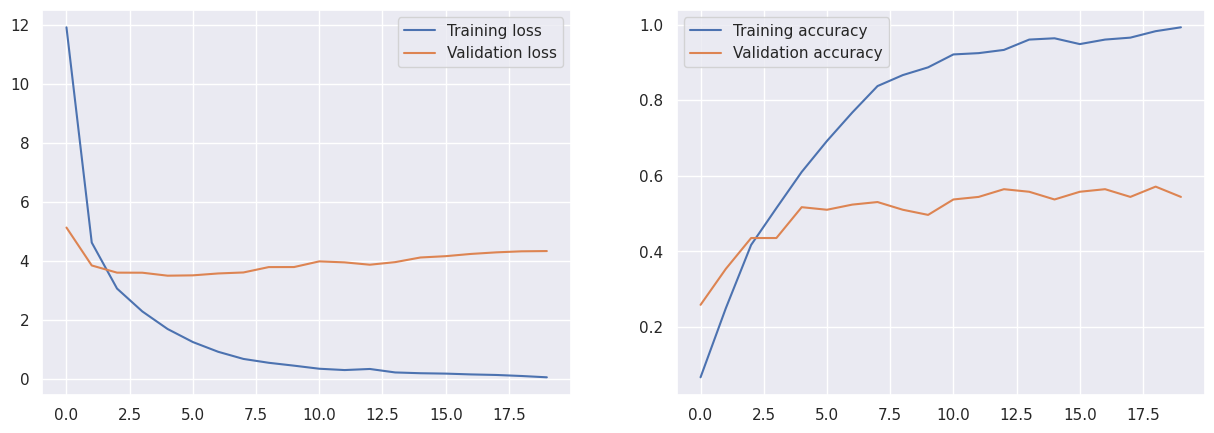

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(history.history['loss'], label='Training loss', ax=axs[0])
sns.lineplot(history.history['val_loss'], label='Validation loss', ax=axs[0])

sns.lineplot(history.history['accuracy'], label='Training accuracy', ax=axs[1])
sns.lineplot(history.history['val_accuracy'], label='Validation accuracy', ax=axs[1])

plt.legend()
plt.show()

Même avec le Dropout à 0.5 (moitié des poids mis à zéro) et moins d'epochs, la différence entre la validation accuracy et la training accuracy reste grande : overfitting.

In [ ]:
comp = pd.DataFrame(index=['Training accuracy', 'Validation accuray', 'Testing accuracy',
                           'Balanced accuracy', 'Overfitting index'])

scores(model_vgg16, 'Baseline')

Losses (training/validation/test) : 0.0/4.33/4.97


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Baseline
Training accuracy,1.000000
Validation accuray,0.544218
Testing accuracy,0.453968
Balanced accuracy,0.202194
Overfitting index,0.500907


Résultats moyens mais meilleures que les prédictions faites dans le notebook précédent via le score ARI.

Les produits appartenant à des catégories peu représentées sont rarement détectés : balanced_accuracy_score faible.

Il y a un overfitting du modèle (index = 0.5), on va donc essayer un modèle avec data augmentation pour agrandir notre jeu de données.

# Modèle avec data augmentation

Couches de data augmentation : RandomFlip, RandomRotation, RandomZoom.

Le nombre d'epochs a, ici aussi, été réduit de 50 à 20.

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    vgg16_2 = create_vgg16_2()
    history = vgg16_2.fit(Xtr, ytr, epochs=20,
                          validation_data=(Xval, yval))

19/19 [==============================] - 3s 169ms/step - loss: 1.2422 - accuracy: 0.6444 - val_loss: 5.0627 - val_accuracy: 0.4354
Epoch 11/20
19/19 [==============================] - 3s 162ms/step - loss: 1.0584 - accuracy: 0.7145 - val_loss: 5.3178 - val_accuracy: 0.4354
Epoch 12/20
19/19 [==============================] - 3s 164ms/step - loss: 1.0284 - accuracy: 0.7060 - val_loss: 5.3833 - val_accuracy: 0.4422
Epoch 13/20
19/19 [==============================] - 3s 162ms/step - loss: 0.9373 - accuracy: 0.7538 - val_loss: 5.4281 - val_accuracy: 0.4694
Epoch 14/20
19/19 [==============================] - 3s 166ms/step - loss: 0.9141 - accuracy: 0.7692 - val_loss: 5.5066 - val_accuracy: 0.4830
Epoch 15/20
19/19 [==============================] - 3s 161ms/step - loss: 0.6648 - accuracy: 0.8137 - val_loss: 5.6794 - val_accuracy: 0.4422
Epoch 16/20
19/19 [==============================] - 3s 161ms/step - loss: 0.6610 - accuracy: 0.8188 - val_loss: 6.1412 - val_accuracy: 0.4694
Epoch 17/20

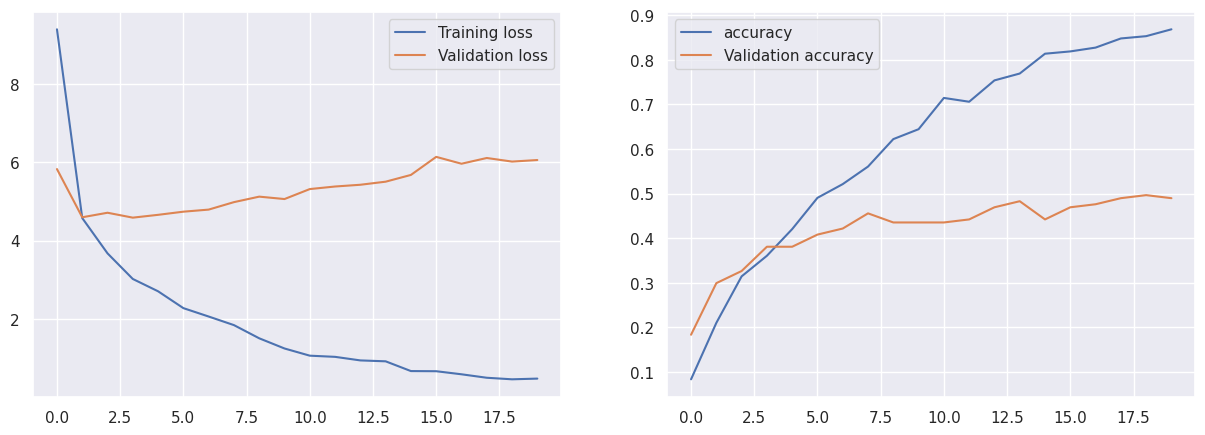

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(history.history['loss'], label='Training loss', ax=axs[0])
sns.lineplot(history.history['val_loss'], label='Validation loss', ax=axs[0])

sns.lineplot(history.history['accuracy'], label='accuracy', ax=axs[1])
sns.lineplot(history.history['val_accuracy'], label='Validation accuracy', ax=axs[1])

plt.legend()
plt.show()

Les pertes au niveau des données de validation augmente avec le nombre d'epochs.

L'écart des performances entre les données d'entraînement et de validation est toujours important.

In [ ]:
scores(vgg16_2, 'Baseline + data aug')

Losses (training/validation/test) : 0.16/6.06/6.67


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Baseline,Baseline + data aug
Training accuracy,1.000000,0.953846
Validation accuray,0.544218,0.489796
Testing accuracy,0.453968,0.457143
Balanced accuracy,0.202194,0.206221
Overfitting index,0.500907,0.480377


Bien qu'il y ai moins d'overfitting, le passage par la data augmentation n'a pas permi de régler le problème.

De plus, cela n'a pas permi d'améliorer nos performances.

On garde les couches de data augmentation et on essaie d'optimiser le modèle.

# VGG16 optimisé

Recherche du meilleur learning_rate pour l'optimizer Adam :

In [ ]:
%pip install keras-tuner
import keras_tuner as kt

In [ ]:
def create_vgg16_kt(hp) :
    # Même modèle de base
    model0 = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
      layer.trainable=False
    # Layers de data augmentation :
    data_augmentation = tf.keras.Sequential([RandomFlip(input_shape=(224, 224, 3)),
                                             RandomRotation((-0.1, 0.1)),
                                             RandomZoom((-0.1, 0.1))])
    # Compléter le modèle
    model = tf.keras.Sequential([data_augmentation,
                                 model0,
                                 GlobalAveragePooling2D(),
                                 Dense(378, activation='relu'),
                                 Dropout(0.5),
                                 Dense(data.label.nunique(), activation='softmax')])
    # Tuning des hyperparamètres de compile()
    learning_rates = hp.Choice('learning_rate', values=[0.1, 1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rates), metrics=["accuracy"])
    return model

In [ ]:
tuner = kt.Hyperband(create_vgg16_kt, objective='accuracy', directory='dir1')

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", mode='min', patience=5, restore_best_weights=True)

with tf.device('/gpu:0'):
  tuner.search(Xtr, ytr, callbacks=[callback])

ATTENTION

Bug keras : impossible d'avoir monitor='accuracy' + mode='min' dans le callback pour minimiser l'overfitting.

  -> EarlyStopping : si, sur au moins 5 epochs de suite, la fonction de perte ne diminue pas l'exécution sera stoppée.

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
print(f"Best learning rate : {best_hps.get('learning_rate')}")

# Modèle avec hyperparamètres + epochs optimisés
hypermodel = tuner.get_best_models()[0]
with tf.device('/gpu:0'):
  history = hypermodel.fit(Xtr, ytr, epochs=20, callbacks=[callback],
                           verbose=0, validation_data=(Xval, yval))

Best learning rate : 0.001


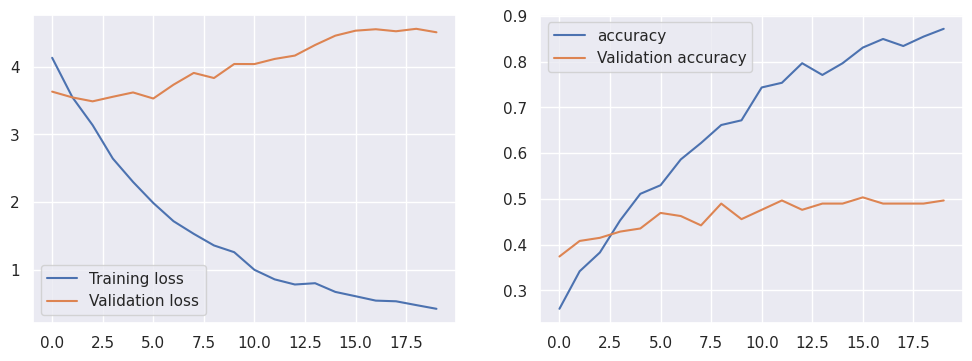

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(history.history['loss'], label='Training loss', ax=axs[0])
sns.lineplot(history.history['val_loss'], label='Validation loss', ax=axs[0])

sns.lineplot(history.history['accuracy'], label='accuracy', ax=axs[1])
sns.lineplot(history.history['val_accuracy'], label='Validation accuracy', ax=axs[1])

plt.legend()
plt.show()

Bien que les pertes soient plus importantes ici, l'écart entre les accuracy à l'air plus faible!

In [ ]:
scores(hypermodel, 'Baseline tuned')

Losses (training/validation/test) : 0.11/4.5/4.94


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Baseline,Baseline + data aug,Baseline tuned
Training accuracy,1.000000,0.953846,0.964103
Validation accuray,0.544218,0.489796,0.496599
Testing accuracy,0.453968,0.457143,0.533333
Balanced accuracy,0.202194,0.206221,0.250043
Overfitting index,0.500907,0.480377,0.449137


L'indice d'overfitting s'améliore peu à peu grâce à l'augmentation des accuracy scores mais les résultats sont toujours peu concluants.

A part via un fine tuning du modèle (qui ne sera pas abordé ici), on a sûrement tiré le meilleur de VGG16.

On essaie maintenant un modèle plus complexe en gardant les méthodes d'optimisation précédntes.

# Modèle plus complexe :  NASNetLarge

In [ ]:
from keras.applications import nasnet

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

Nouveau callback : arrêt d'éxécution si, pendant au moins 5 epochs, la validation accuracy n'augmente pas.

In [ ]:
def create_nasnet() :
    # NASNet = modèle de base
    model0 = nasnet.NASNetLarge(include_top=False, weights="imagenet",
                                input_shape=(224, 224, 3))
    for layer in model0.layers:
      layer.trainable=False
    # Layers de data augmentation :
    data_augmentation = tf.keras.Sequential([RandomFlip(input_shape=(224, 224, 3)),
                                             RandomRotation((-0.1, 0.1)),
                                             RandomZoom((-0.1, 0.1))])
    # Compléter le modèle
    model = tf.keras.Sequential([data_augmentation,
                                 model0,
                                 GlobalAveragePooling2D(),
                                 Dense(378, activation='relu'),
                                 Dropout(0.5),
                                 Dense(data.label.nunique(), activation='softmax')])
    # compilation du modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

Ré-import et prétraitement des images : utilisation de preprocess_input() du module nasnet.

In [ ]:
Xtr, Xval, Xte, ytr, yval, yte = split_prep(nasnet)

In [ ]:
# Modèle avec epochs optimisés
model1 = create_nasnet()
with tf.device('/gpu:0'):
  history = model1.fit(Xtr, ytr, epochs=20,
                       callbacks=[es], validation_data=(Xval, yval))

Epoch 1/20
19/19 [==============================] - 39s 937ms/step - loss: 4.6158 - accuracy: 0.1778 - val_loss: 3.7118 - val_accuracy: 0.3537
Epoch 2/20
19/19 [==============================] - 10s 545ms/step - loss: 3.1551 - accuracy: 0.3846 - val_loss: 3.5062 - val_accuracy: 0.3605
Epoch 3/20
19/19 [==============================] - 10s 546ms/step - loss: 2.4609 - accuracy: 0.4821 - val_loss: 3.5375 - val_accuracy: 0.3878
Epoch 4/20
19/19 [==============================] - 9s 466ms/step - loss: 2.1137 - accuracy: 0.5197 - val_loss: 3.4706 - val_accuracy: 0.3605
Epoch 5/20
19/19 [==============================] - 9s 468ms/step - loss: 1.7378 - accuracy: 0.6256 - val_loss: 3.5364 - val_accuracy: 0.3878
Epoch 6/20
19/19 [==============================] - 9s 504ms/step - loss: 1.4504 - accuracy: 0.6513 - val_loss: 3.6712 - val_accuracy: 0.3946
Epoch 7/20
19/19 [==============================] - 9s 503ms/step - loss: 1.2228 - accuracy: 0.6923 - val_loss: 3.6274 - val_accuracy: 0.3878
Epo

Callback intervenu après 14 epochs sur 20 : la validation accuracy a cessé de s'améliorer.

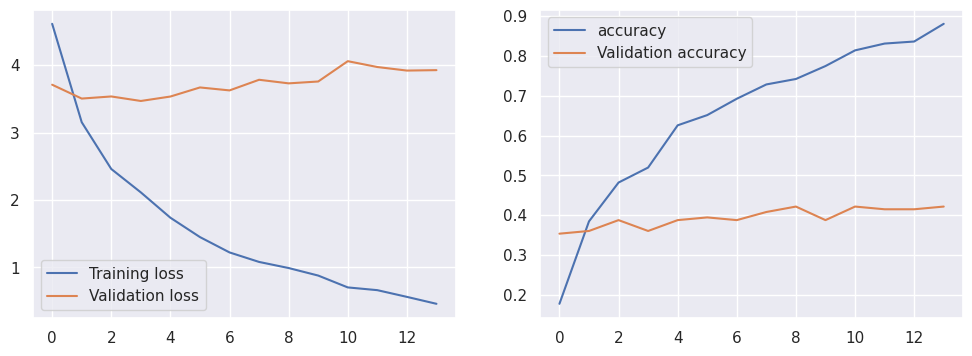

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(history.history['loss'], label='Training loss', ax=axs[0])
sns.lineplot(history.history['val_loss'], label='Validation loss', ax=axs[0])

sns.lineplot(history.history['accuracy'], label='accuracy', ax=axs[1])
sns.lineplot(history.history['val_accuracy'], label='Validation accuracy', ax=axs[1])

plt.legend()
plt.show()

Globalement on a les mêmes graphes qu'avant : pas d'amélioration nette.

In [ ]:
scores(model1, 'NasNet')

Losses (training/validation/test) : 0.68/3.73/3.14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Baseline,Baseline + data aug,Baseline tuned,NasNet
Training accuracy,1.000000,0.953846,0.964103,0.849573
Validation accuray,0.544218,0.489796,0.496599,0.421769
Testing accuracy,0.453968,0.457143,0.533333,0.460317
Balanced accuracy,0.202194,0.206221,0.250043,0.230281
Overfitting index,0.500907,0.480377,0.449137,0.408530


+ Moins de la moitié des données non vues pendant l'entraînement sont bien classées
+ Il y a un peu moins d'overfitting : index minimum.
+ Il y a moins de produits appartenant à une catégorie peu représentée qui ont été bien classés (balanced_accuracy_score = 0.2 < 0.25)

Les résultats sont toujours moyens et il est difficile de choisir le meilleur modèle : certains points se sont améliorés et d'autres empirés.

# Combinaison de Deep Learning et Machine Leaarning

Deep Learning : utilisé pour le feature extraction.

Machine Learning : utilisé pour la classification.

In [ ]:
model = vgg16.VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
'''
tmp = data['label'].value_counts()
labels = tmp[tmp>1].index
# Enlever les catégories n'apparaissant qu'une fois : on garde le balanced_accuracy score car les cat restantes sont toujours non équilibrées.
data = data.loc[data.label.isin(labels)]
'''

Ré-import des images : ajout d'un filtre gaussien en plus du passeg par preprocesss_input() du module vgg16.

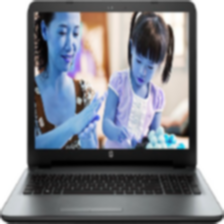

(910, 4096)

In [ ]:
features = []

with tf.device('/gpu:0'):
  for i in data['image_name'].index:
    img = load_img('/content/drive/MyDrive/Colab Notebooks/Projet 6/Images/'+str(data['image_name'][i]),
                   target_size=(224, 224))
    img = img_to_array(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    if i == 500 : cv2_imshow(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    features.append(model.predict(img, verbose=0)[0])

features = np.array(features)
features.shape

In [ ]:
X = features
y = data['label']

'''
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)
'''
# Essais avec with_mean=False et avec with_std=False : pas d'amélioration des résultats.
'''
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)
'''
# La réduction de dimensions a mené à des accuracy scores plus faibles : on reste à 4096 features
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)

print("Dimensions of input training data:",X_train.shape)
print("Dimensions of input testing data:",X_test.shape)

Dimensions of input training data: (728, 4096)
Dimensions of input testing data: (182, 4096)


Un essai de normalisation (StandardScaling) à été effectué : non concluant.
De même pour la réduction de dimensions.

Toujours dans un souci de minimisation de l'overfitting, le train_size a été augmenté : de 0.7 à 0.8

In [ ]:
svc = SVC()

gs = GridSearchCV(svc, cv=3, param_grid={'C': np.logspace(-6, 6, 13),
                                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})
with tf.device('/gpu:0'):
  gs.fit(X_train, y_train)

gs.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [ ]:
best_svc = gs.best_estimator_.fit(X_train, y_train)
y_pred = best_svc.predict(X_test)

comp['VGG16 + SVC'] = [best_svc.score(X_train, y_train), None, best_svc.score(X_test, y_test),
                       balanced_accuracy_score(y_test, y_pred), best_svc.score(X_train, y_train)-best_svc.score(X_test, y_test)]

comp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Baseline,Baseline + data aug,Baseline tuned,NasNet,VGG16 + SVC
Training accuracy,1.000000,0.953846,0.964103,0.849573,0.994505
Validation accuray,0.544218,0.489796,0.496599,0.421769,NaN
Testing accuracy,0.453968,0.457143,0.533333,0.460317,0.631868
Balanced accuracy,0.202194,0.206221,0.250043,0.230281,0.477736
Overfitting index,0.500907,0.480377,0.449137,0.408530,0.362637


+ Nouveau minimum pour l'index d'overfitting : différnce de 0.36 entre training et testing accuracy.
+ Nouveaux maximums pour les accuracy scores : 63% des images non vues pendant l'entrînelent ont été correctement classées.
+ Le balanced_accuracy_score a été pratiquement doublé ! : le modèle classe mieux les images à catégories peu représentées dans le dataset.


CONCLUSION

Pour le dataset donné, la combinaison de VGG16 et SVC donne les meilleurs résultats.

La classification automatique des images en catégories de produits n'est pas optimale, elle reste sûrement moins performante qu'une classification à la main par les vendeurs.

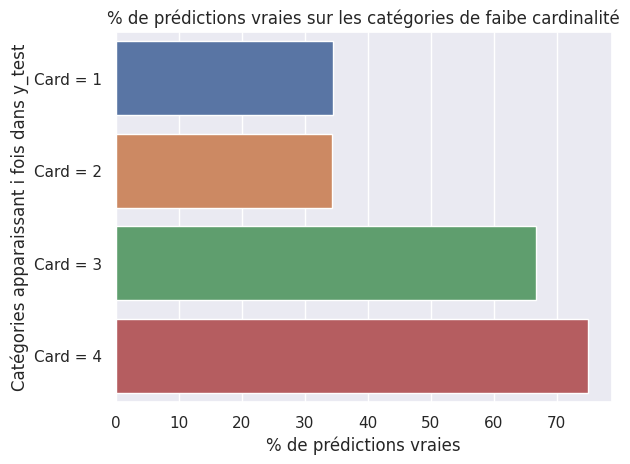

In [ ]:
result = pd.DataFrame({'original': y_test,'predicted': y_pred})

perc = []
for i in range(1, 5):
  low_card = result['original'].value_counts()[result['original'].value_counts()==i]
  low_card_pred = result.loc[result['original'].isin(low_card.index)]
  count = 0
  for j in low_card_pred.index:
    if low_card_pred['original'][j]==low_card_pred['predicted'][j]:
      count+=1
  perc.append(np.round((count/low_card_pred.shape[0])*100, 2))

plt.title("% de prédictions vraies sur les catégories de faibe cardinalité")
plt.xlabel(("% de prédictions vraies"))
plt.ylabel("Catégories apparaissant i fois dans y_test")
sns.barplot(x=perc, y=['Card = 1', 'Card = 2', 'Card = 3', 'Card = 4'])
plt.show()

L'utilisation d'un modèle n'est pas recommandé ici.

Lorsque le nombre de produits en ligne sera plus important (nombre de produits >> 1050), et surtout lorsque chaque catégories apparait AU MOINS 5 fois, nous pourrons créer un modèle de classification suffisemment performant pour cette tâche.